**Import necessary Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

**Load Data**

In [2]:
def load_data_from_csv(filename):
    # Read the CSV file
    df = pd.read_csv(filename)

    # Extract features (x1, x2) and true labels (y)
    data = df[['x1', 'x2']].values
    true_labels = df['y'].values

    return data, true_labels

**Eucledian Distance**

In [3]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

**Selecting the k-representative points (centroids) for the k-clusters**

In [4]:
def initialize_centroids(data, k):
    n_samples = len(data)
    # Choose first centroid randomly
    centroids = [data[np.random.randint(n_samples)]]

    # Choose remaining centroids
    for _ in range(k - 1):
        # Calculate distances from points to nearest centroid
        distances = np.array([min([euclidean_distance(point, cent) for cent in centroids])
                            for point in data])
        # Choose next centroid with probability proportional to distance squared
        probs = distances ** 2 / np.sum(distances ** 2)
        cumprobs = np.cumsum(probs)
        r = np.random.random()
        ind = np.searchsorted(cumprobs, r)
        centroids.append(data[ind])

    return np.array(centroids)

**Assigning each data point to the nearest centroid**

In [5]:
def assign_clusters(data, centroids):

    n_samples = len(data)
    cluster_labels = np.zeros(n_samples)

    for i in range(n_samples):
        distances = [euclidean_distance(data[i], centroid) for centroid in centroids]
        cluster_labels[i] = np.argmin(distances)

    return cluster_labels

**Updating centroid postions based on mean of assigned points**

In [6]:
def update_centroids(data, cluster_labels, k):

    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))

    for i in range(k):
        cluster_points = data[cluster_labels == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)

    return centroids

**Cluster metrics (Inertia: within-cluster sum-of-squares)**

In [7]:
def calculate_inertia(data, cluster_labels, centroids):
    total_distance = 0
    for i in range(len(data)):
        centroid = centroids[int(cluster_labels[i])]
        total_distance += euclidean_distance(data[i], centroid) ** 2
    return total_distance

**k-means Driver Code**

In [8]:
def kmeans(data, k, max_iterations=100, tolerance=1e-4):
    best_inertia = float('inf')
    best_labels = None
    best_centroids = None

    # Run multiple times with different initializations
    n_init = 10
    for init in range(n_init):
        # Initialize centroids using k-means++
        centroids = initialize_centroids(data, k)

        for iteration in range(max_iterations):
            old_centroids = centroids.copy()

            # Assign clusters
            cluster_labels = assign_clusters(data, centroids)

            # Update centroids
            centroids = update_centroids(data, cluster_labels, k)

            # Check convergence
            centroid_shift = np.sum([euclidean_distance(old_centroids[i], centroids[i])
                                   for i in range(k)])

            if centroid_shift < tolerance:
                print(f"Run {init + 1}: Converged after {iteration + 1} iterations")
                break

        # Calculate inertia for this run
        inertia = calculate_inertia(data, cluster_labels, centroids)

        # Update best result if this run is better
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = cluster_labels
            best_centroids = centroids

    return best_labels, best_centroids, best_inertia

**Evaluation Metrics**

In [9]:
def calculate_clustering_metrics(true_labels, predicted_labels):
    # Calculate purity
    contingency_matrix = {}
    for true, pred in zip(true_labels, predicted_labels):
        if true not in contingency_matrix:
            contingency_matrix[true] = Counter()
        contingency_matrix[true][pred] += 1

    total_correct = sum(max(counts.values()) for counts in contingency_matrix.values())
    purity = total_correct / len(true_labels)

    # Calculate cluster sizes
    cluster_sizes = Counter(predicted_labels)

    return {
        'purity': purity,
        'cluster_sizes': cluster_sizes
    }

**Result Visualization**

In [10]:
def plot_clusters(data, cluster_labels, centroids, true_labels=None):
    plt.figure(figsize=(15, 6))

    # Plot predicted clusters
    plt.subplot(121)
    scatter = plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1],
               c='red', marker='x', s=200, linewidths=3,
               label='Centroids')
    plt.title('K-means Clustering Results')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()

    # Plot true labels if provided
    if true_labels is not None:
        plt.subplot(122)
        plt.scatter(data[:, 0], data[:, 1], c=true_labels, cmap='viridis')
        plt.title('True Labels')
        plt.xlabel('x1')
        plt.ylabel('x2')

    plt.tight_layout()
    plt.show()

**Testing the algorithm with datasets**: Dataset 1

Run 1: Converged after 11 iterations
Run 2: Converged after 12 iterations
Run 3: Converged after 22 iterations
Run 4: Converged after 33 iterations
Run 5: Converged after 13 iterations
Run 6: Converged after 17 iterations
Run 7: Converged after 8 iterations
Run 8: Converged after 6 iterations
Run 9: Converged after 19 iterations
Run 10: Converged after 10 iterations

Clustering Results:
Inertia (within-cluster sum of squares): 5175.16
Purity Score: 0.366

Cluster Sizes:
Cluster 2.0: 245 points
Cluster 3.0: 220 points
Cluster 1.0: 235 points


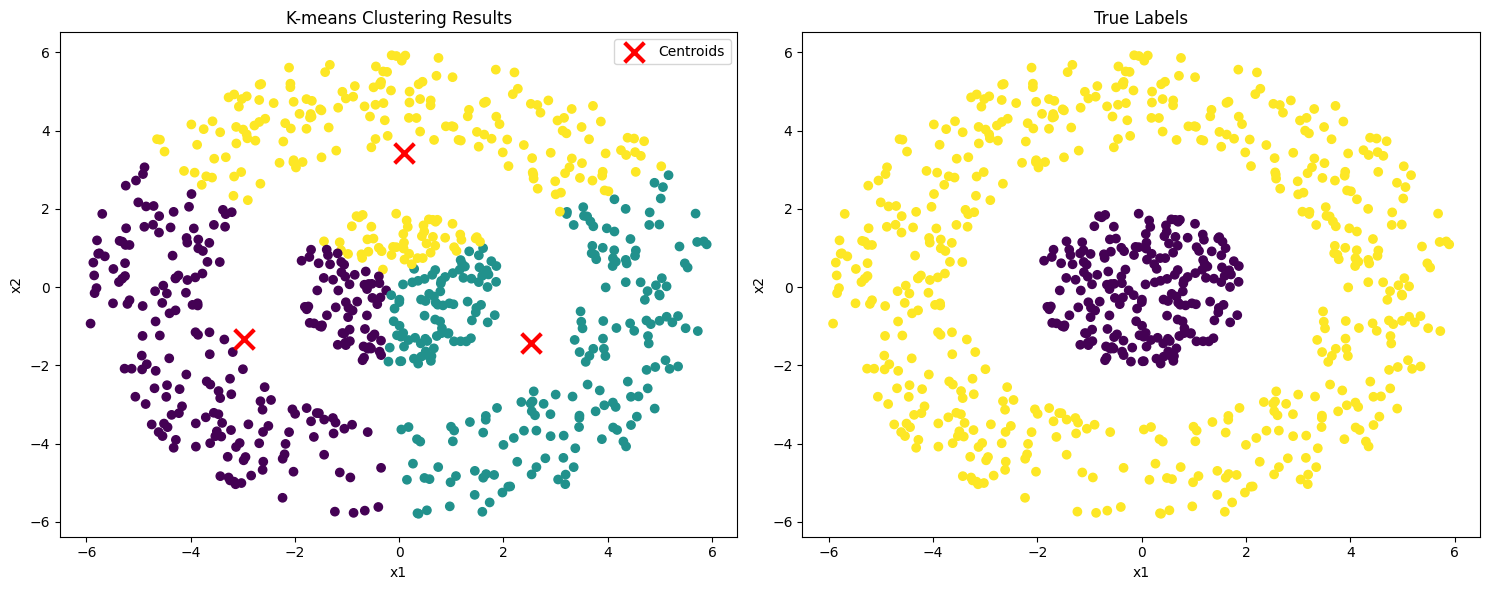

In [11]:
if __name__ == "__main__":
    # Load data from CSV file
    data, true_labels = load_data_from_csv('data_1.csv')

    # Apply k-means clustering
    k = 3  # We know there are 3 clusters from the true labels
    cluster_labels, centroids, inertia = kmeans(data, k)

    # Calculate clustering metrics
    metrics = calculate_clustering_metrics(true_labels, cluster_labels)

    # Print results
    print("\nClustering Results:")
    print(f"Inertia (within-cluster sum of squares): {inertia:.2f}")
    print(f"Purity Score: {metrics['purity']:.3f}")
    print("\nCluster Sizes:")
    for cluster_id, size in metrics['cluster_sizes'].items():
        print(f"Cluster {cluster_id + 1}: {size} points")

    # Visualize results
    plot_clusters(data, cluster_labels, centroids, true_labels)

**Testing the algorithm with datasets**: Dataset 2

Run 1: Converged after 7 iterations
Run 2: Converged after 6 iterations
Run 3: Converged after 5 iterations
Run 4: Converged after 5 iterations
Run 5: Converged after 5 iterations
Run 6: Converged after 11 iterations
Run 7: Converged after 7 iterations
Run 8: Converged after 4 iterations
Run 9: Converged after 3 iterations
Run 10: Converged after 4 iterations

Clustering Results:
Inertia (within-cluster sum of squares): 1443.36
Purity Score: 0.880

Cluster Sizes:
Cluster 1.0: 136 points
Cluster 2.0: 89 points
Cluster 3.0: 75 points


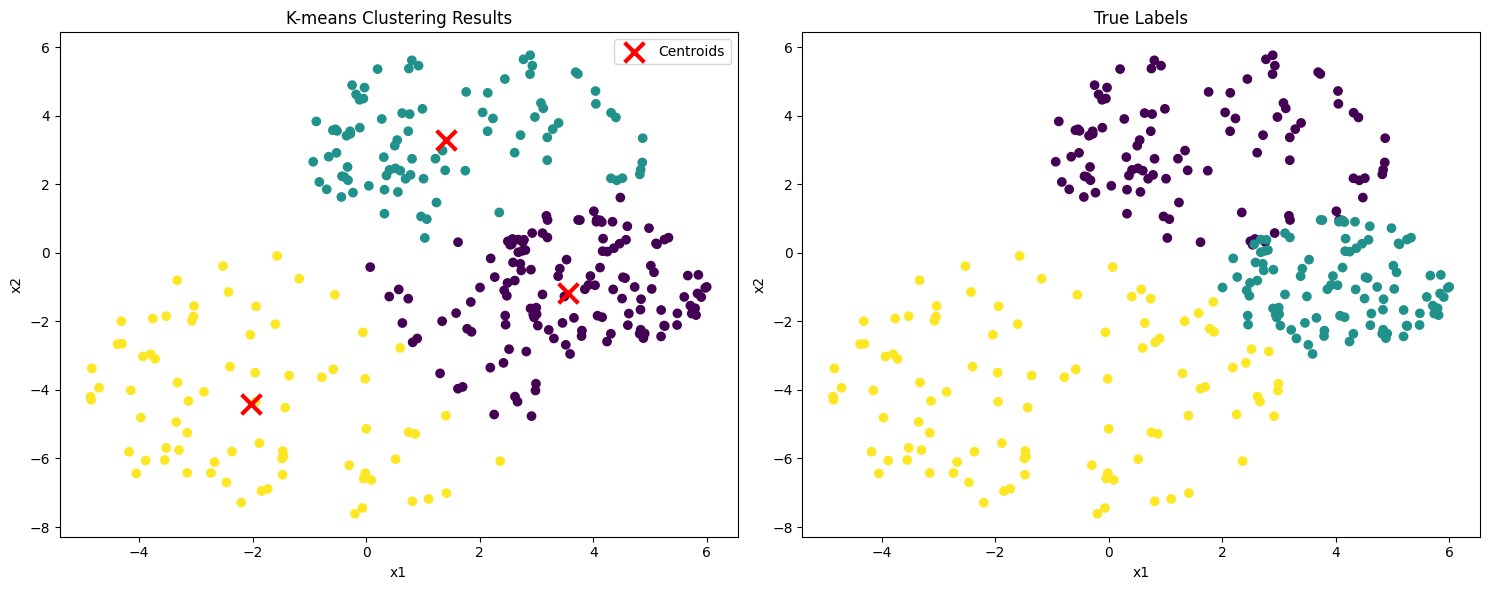

In [12]:
if __name__ == "__main__":
    # Load data from CSV file
    data, true_labels = load_data_from_csv('data_2.csv')

    # Apply k-means clustering
    k = 3  # We know there are 3 clusters from the true labels
    cluster_labels, centroids, inertia = kmeans(data, k)

    # Calculate clustering metrics
    metrics = calculate_clustering_metrics(true_labels, cluster_labels)

    # Print results
    print("\nClustering Results:")
    print(f"Inertia (within-cluster sum of squares): {inertia:.2f}")
    print(f"Purity Score: {metrics['purity']:.3f}")
    print("\nCluster Sizes:")
    for cluster_id, size in metrics['cluster_sizes'].items():
        print(f"Cluster {cluster_id + 1}: {size} points")

    # Visualize results
    plot_clusters(data, cluster_labels, centroids, true_labels)